In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from lxml import etree


def lon_lat_path_to_gpx(lon_lat_path, filename):
    
    """
    Write the list of lon, lat coordinates to a 
    GPX (XML) file.
    """
    
    track = etree.Element('trk')
    doc = etree.ElementTree(track)
    segment = etree.SubElement(track, 'trkseg')

    for point in lon_lat_path:
        lon, lat = point
        
        point = etree.SubElement(
            segment,
            'trkpt',
            lon=str(lon), 
            lat=str(lat)
        )

    tree = track.getroottree()
    fn = './' + filename + '.gpx'
    
    tree.write(
        fn, 
        pretty_print=True,
        xml_declaration=True, 
        encoding='utf-8'
    )


def animate_from_path(
    lon_lat_path,
    original_edges,
    file_name,
    fig_size,
    frame_share,
    dpi
):
    """
    Create GIF animation of path from lon, lat
    coordinates. Projects the points in the path to UTM
    and uses the GeoDataFrame.plot() method to plot the
    background edges.
    """
    
    points = [Point(x, y) for x, y in lon_lat_path]
    series = gpd.GeoSeries(points)

    gdf = gpd.GeoDataFrame(geometry=series,
                           crs=original_edges.crs)
    
    gdf = ox.project_gdf(gdf)

    increment = int(1/frame_share)
    
    x, y = gdf.geometry.x, gdf.geometry.y
    x, y = x.tolist(), y.tolist()
    x, y = x[::increment], y[::increment]
    
    plt.ioff()
    
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    for key, spine in ax.spines.items():
        spine.set_visible(False)

    ax.tick_params(left=False, 
                   bottom=False)
    
    ax.tick_params(labelleft=False, 
                   labelbottom=False)

    p = 200
    
    ax.set_xlim([min(x)-p, max(x)+p])
    ax.set_ylim([min(y)-p, max(y)+p])

    bg_edges = ox.project_gdf(original_edges)
    
    bg_edges.plot(
        ax=ax, 
        color='black', 
        alpha=0.5,
        lw=1/5*fig_size
    )

    point, = ax.plot(
        [], 
        [], 
        color='red',
        marker='o',
        ms=4/5*fig_size
    )
    
    line, = ax.plot(
        [], 
        [], 
        color='red', 
        alpha=0.2, 
        lw=4/5*fig_size
    )

    
    def animate(i):
        point.set_data(x[i], y[i])
        line.set_data(x[:i],y[:i])
        return point, line

    
    animation = FuncAnimation(
        fig=ax.figure, 
        func=animate, 
        frames=len(x), 
        interval=50, 
        blit=True
    )
    
    fps = 40*frame_share
    fp = './' + file_name + '.gif'
    
    animation.save(
        filename=fp, 
        dpi=dpi, 
        fps=fps
    )
    

def get_source_node(
    start_lon_lat,
    original_edge_gdf,
    original_node_gdf
):
    """
    Return closest OSM node in street network, when a 
    custom lon,lat starting point is provided by user.
    """
    
    start_point = Point(start_lon_lat)
    start_lon_lat_series = gpd.GeoSeries([start_point])

    start_lon_lat_gdf = gpd.GeoDataFrame(
        geometry=start_lon_lat_series,
        crs=original_edge_gdf.crs
    )

    start_lon_lat_gdf = ox.project_gdf(start_lon_lat_gdf)
    projected_nodes = ox.project_gdf(original_node_gdf)

    start_geom = start_lon_lat_gdf.geometry.iloc[0]
    geoms = projected_nodes.geometry

    distances = geoms.apply(lambda x: x.distance(start_geom))
    source = distances.idxmin()
    
    return source
    
    
def eulerian_path_from_place(
    query, 
    network_type='all_private',
    path_type='circuit',
    start_lon_lat=None,
    save_path_as_gpx=False,
    save_animation=False,
    animation_fig_size=5,
    animation_frame_share=1,
    animation_dpi=80
):
    """
    Return Eulerian circuit or path as LineString, from city name. 
    The query is passed to OSMnx.graph.graph_from_place. It must 
    be geocodable and have polygon boundaries.  
    """
    
    city = ox.graph.graph_from_place(
        query, 
        network_type=network_type
    )
    
    city = city.to_undirected()
    original_nodes, original_edges = ox.graph_to_gdfs(city)
    
    if start_lon_lat is not None:
        source = get_source_node(
            start_lon_lat,
            original_edges,
            original_nodes
        )
        
    else:
        source = None
    
    if path_type == 'path':
        if nx.has_eulerian_path(city):
            path = list(nx.eulerian_path(city,source=source))
            
        else:
            raise nx.NetworkXError('Graph has no Eulerian paths.')
            
    if path_type == 'circuit':      
        if not nx.is_eulerian(city):
            city = nx.eulerize(city)

        path = list(nx.eulerian_circuit(city,source=source))
            
    origin_id = path[0][0]
    origin_node = original_nodes.loc[origin_id]

    lon_lat_path = [(origin_node.x, origin_node.y)]
    
    index = original_edges.index
    step_dic = {edge:0 for edge in path}
    
    for edge in path:
        is_edge = [set(edge).issubset(i) for i in index]  
        gdf_edges = original_edges[is_edge]
        
        geom = gdf_edges.geometry   
        step = step_dic[edge]
        
        coords = list(geom.iloc[step].coords)

        test_order = lon_lat_path[-1] == coords[0]  
        order = 1 if test_order else -1
        lon_lat_path.extend(coords[::order])

        n_edges = len(gdf_edges)

        if n_edges > 1:
            step_dic[edge] = (step + 1) % n_edges
            
    if save_path_as_gpx == True:
        lon_lat_path_to_gpx(lon_lat_path, query)
        
    if save_animation == True:
        animate_from_path(
            lon_lat_path,
            original_edges,
            query,
            animation_fig_size,
            animation_frame_share,
            animation_dpi
        )
                    
    lon_lat_path = LineString(lon_lat_path)
    
    return lon_lat_path

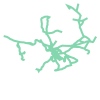

In [5]:
start = (4.373818, 45.318257)

test_path = eulerian_path_from_place(
    'Jonzieux',
    network_type='drive',
    start_lon_lat=start, 
    save_path_as_gpx=True,
    save_animation=True,
    animation_fig_size=5
)